In [1]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data_dark//train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data_dark/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '../../../Bai_4/data_dark/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Small

# Base model
base_model = MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Functional API
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,687 (3.90 MB)

 Trainable params: 670,759 (2.56 MB)

 Non-trainable params: 350,928 (1.34 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 171s 232ms/step - accuracy: 0.4009 - loss: 1.5390 - val_accuracy: 0.5025 - val_loss: 1.2986
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 166s 232ms/step - accuracy: 0.5491 - loss: 1.2130 - val_accuracy: 0.5567 - val_loss: 1.1995
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 207s 288ms/step - accuracy: 0.5971 - loss: 1.0864 - val_accuracy: 0.5839 - val_loss: 1.1234
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 184s 256ms/step - accuracy: 0.6312 - loss: 1.0026 - val_accuracy: 0.5804 - val_loss: 1.1522
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 188s 261ms/step - accuracy: 0.6692 - loss: 0.9048 - val_accuracy: 0.5799 - val_loss: 1.1585
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 175s 244ms/step - accuracy: 0.7022 - loss: 0.8161 - val_accuracy: 0.5914 - val_loss: 1.1871


7178/7178 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - accuracy: 0.5094 - loss: 1.2678
Test Accuracy: 58.86%
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step


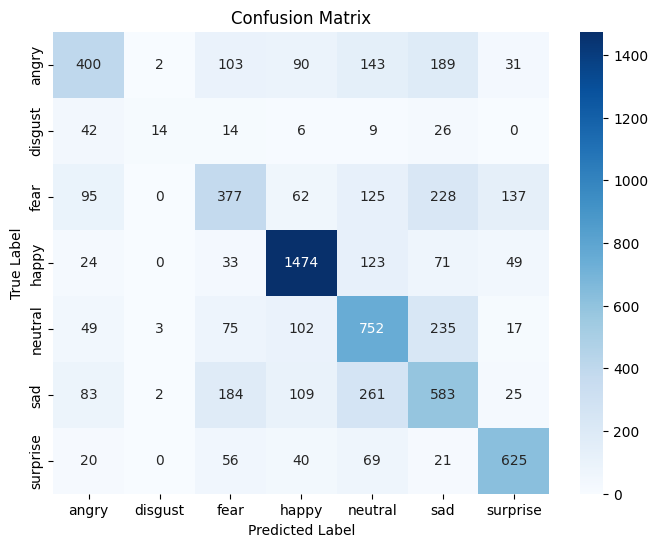

In [8]:
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [10]:
model.save("mobilenetv3_fer2013_low_light_V2.keras")  # lưu đúng định dạng mới
size_mb = os.path.getsize("mobilenetv3_fer2013_low_light_V2.keras") / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

Model Size: 9.59 MB


In [9]:
from sklearn.metrics import f1_score

# F1-Score macro (trung bình đều các lớp)
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# F1-Score micro (toàn bộ TP, FP, FN gộp lại)
f1_micro = f1_score(y_true, y_pred_classes, average='micro')

# F1-Score weighted (có tính đến số lượng mẫu từng lớp)
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1-Score (Macro): {f1_macro * 100:.2f}%")
print(f"F1-Score (Micro): {f1_micro * 100:.2f}%")
print(f"F1-Score (Weighted): {f1_weighted * 100:.2f}%")

F1-Score (Macro): 51.89%
F1-Score (Micro): 58.86%
F1-Score (Weighted): 58.15%


In [11]:
# Inference Time
import time
start = time.time()
_ = model.predict(test_generator)
end = time.time()

inference_time = (end - start) / len(test_generator.filenames) * 1000  # ms per image
print(f"Average Inference Time: {inference_time:.2f} ms/image")

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step
Average Inference Time: 12.23 ms/image
